In [51]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import torch
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from pprint import pprint as pp

from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

from torch import cuda
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
plt.style.use('seaborn')

In [52]:
data = []
# load data
with open('S21-gene-train.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        line = line.split('\t')
        # if line == ['']:
        #     continue
        data.append(line)

In [53]:
# make a dataframe
df = pd.DataFrame(data=data, columns=['Sequence', 'Word', 'Tag'])

# debug
print('head')
print(df.head(20))

head
   Sequence                Word   Tag
0         1          Comparison     O
1         2                with     O
2         3            alkaline     B
3         4        phosphatases     I
4         5                 and     O
5         6                   5     B
6         7                   -     I
7         8        nucleotidase     I
8         9                   .     O
9                          None  None
10        1       Pharmacologic     O
11        2             aspects     O
12        3                  of     O
13        4            neonatal     O
14        5  hyperbilirubinemia     O
15        6                   .     O
16                         None  None
17        1                When     O
18        2                 CSF     O
19        3                   [     O


In [54]:
# indices of new sentence rows
new_sent_idx = np.array(df[df['Sequence'] == ''].index+1)
new_sent_idx = np.insert(new_sent_idx, 0, 0)
print('new_sent_idx')
print(new_sent_idx)

new_sent_idx
[     0     10     17 ... 399880 399916 399948]


In [55]:
# get B, I, O tag counts
df_counts = df.groupby('Tag').size().reset_index(name='counts')
print('df_counts')
print(df_counts)

df_counts
  Tag  counts
0   B   16637
1   I   24435
2   O  345129


In [56]:
firstline = True
df_work = pd.DataFrame(columns=['LineStartIdx', 'Words', 'Tags'])
for idx, line in enumerate(new_sent_idx):
    if firstline:
        strng = df.iloc[new_sent_idx[idx]:new_sent_idx[idx+1]-1, 1].to_list()
        labels = df.iloc[new_sent_idx[idx]:new_sent_idx[idx+1]-1, 2].to_list()
        firstline = False
    else:
        try:
            strng = df.iloc[new_sent_idx[idx]:new_sent_idx[idx+1]-1, 1].to_list()
            labels = df.iloc[new_sent_idx[idx]:new_sent_idx[idx+1]-1, 2].to_list()
        except:
            strng = df.iloc[new_sent_idx[idx]:-1, 1].to_list()
            labels = df.iloc[new_sent_idx[idx]:-1, 2].to_list()

    seq = ' '.join(strng)
    labl = ','.join(labels)
    df_work = df_work.append({'LineStartIdx': line, 
                            'Words': seq, 
                            'Tags': labl}, ignore_index=True)
print(df_work)

      LineStartIdx                                              Words  \
0                0  Comparison with alkaline phosphatases and 5 - ...   
1               10  Pharmacologic aspects of neonatal hyperbilirub...   
2               17  When CSF [ HCO3 -] is shown as a function of C...   
3               63  Flurazepam thus appears to be an effective hyp...   
4               88                             Beta blocking agents .   
...            ...                                                ...   
13791       399806  Because the high - density lipoprotein recepto...   
13792       399845  IFN - stimulated gene factor - 3 and STAT1 hom...   
13793       399880  We have therefore studied the molecular mechan...   
13794       399916  The epitope - protected lysine ( K ) was prese...   
13795       399948  To understand the molecular regulation of thes...   

                                                    Tags  
0                                      O,O,B,I,O,B,I,I,O  
1    

In [57]:
# getting sentence word, tag sequences in list format
sequences = []
for row in df_work.values:
    sen_seq = [(w, t) for w, t in zip(row[1].split(' '), row[2].split(','))]
    sequences.append(sen_seq)
print(sequences[5])

[('When', 'O'), ('extracorporeal', 'O'), ('CO2', 'O'), ('removal', 'O'), ('approximated', 'O'), ('CO2', 'O'), ('production', 'O'), ('(', 'O'), ('VCO2', 'O'), ('),', 'O'), ('alveolar', 'O'), ('ventilation', 'O'), ('almost', 'O'), ('ceased', 'O'), ('.', 'O')]


In [58]:
df2 = df.dropna()

# get list of words
words=list(set(df2['Word'].values))
words.append("ENDPAD")
print(words[-1])
num_words = len(words)

ENDPAD


In [59]:
#Total no. of words
print("Total number of words",num_words)

Total number of words 31329


In [60]:
#List of Tags and total no. of Tags
tags = list(set(df2["Tag"].values))
num_tags = len(tags)
print(num_tags)
print(tags)
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

3
['B', 'O', 'I']
List of tags: B, O, I
Total Number of tags 3


Text(0.5, 0, 'Length of Sentences')

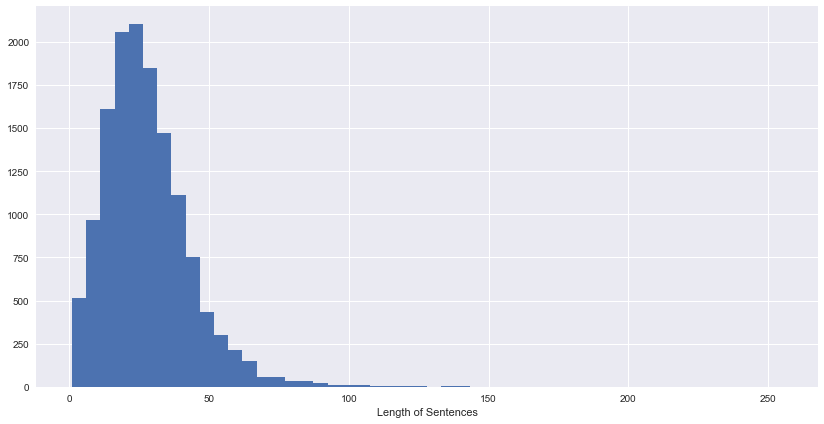

In [61]:
# average words per sentence
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sequences],bins = 50)
plt.xlabel("Length of Sentences")
# plt.show()

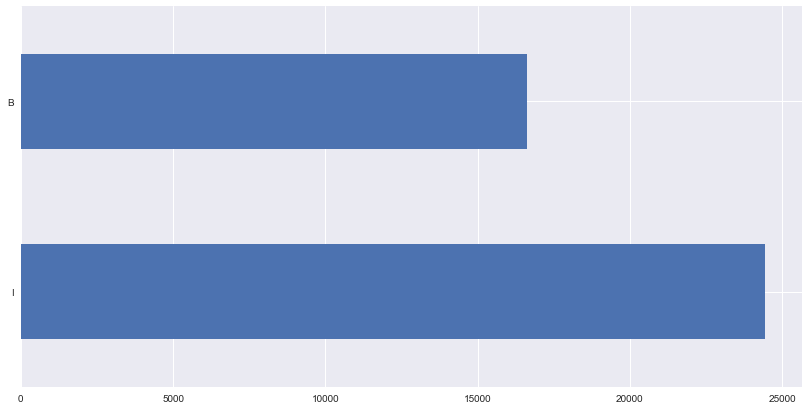

In [62]:
# plot of B, I occurences
plt.figure(figsize=(14, 7))
df.Tag[df.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();
# plt.show()

In [63]:
print(words[:5])
print(tags[:5])

word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}
# print(word_idx)
print(tag_idx)
print(word_idx['Rieske'])

['organising', 'multivariative', 'airflow', 'preload', '201Tl']
['B', 'O', 'I']
{'B': 0, 'O': 1, 'I': 2}
19800


In [64]:
print(sequences[9])

[('The', 'O'), ('variable', 'O'), ('HMG', 'B'), ('dosage', 'O'), ('regimen', 'O'), ('was', 'O'), ('found', 'O'), ('to', 'O'), ('offer', 'O'), ('no', 'O'), ('advantages', 'O'), ('when', 'O'), ('compared', 'O'), ('with', 'O'), ('our', 'O'), ('standard', 'O'), ('daily', 'O'), ('dosage', 'O'), ('regimen', 'O'), ('.', 'O')]


In [65]:
# Padding our sentences using max lenght of 50.
max_len=100
X=[[word_idx[w[0]] for w in s] for s in sequences]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
y=[[tag_idx[w[1]]for w in s]for s in sequences]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])
print(sequences[0])
print(X[0])
print(y[0])
y=[to_categorical(i,num_classes=num_tags) for i in y]
# print(y[0])

[('Comparison', 'O'), ('with', 'O'), ('alkaline', 'B'), ('phosphatases', 'I'), ('and', 'O'), ('5', 'B'), ('-', 'I'), ('nucleotidase', 'I'), ('.', 'O')]
[23513   214 17905 20189 14815  1225 11988  1564  9706 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328 31328
 31328 31328 31328 31328]
[1 1 0 2 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [66]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [17]:
# build model
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=len(words),output_dim=max_len,input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Metal device set to: Apple M1 Max
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          3132900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 3)            603       
Total params: 3,294,303
Trainable params: 3,294,303
Non-trainable params: 0
_________________________________________________________________
None


2021-11-25 05:36:16.737455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-25 05:36:16.737575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
plot_model(model,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [19]:
#Training the model with Training data
model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=5,validation_split=0.15)

2021-11-25 05:36:16.904593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-25 05:36:16.904771: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/3


2021-11-25 05:36:17.659433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9651 

2021-11-25 06:48:43.447249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 4376s 28s/step - loss: 0.1448 - accuracy: 0.9651 - val_loss: 0.0764 - val_accuracy: 0.9747
Epoch 2/3
156/156 [==============================] - 4679s 30s/step - loss: 0.0601 - accuracy: 0.9781 - val_loss: 0.0517 - val_accuracy: 0.9818
Epoch 3/3
156/156 [==============================] - 4340s 28s/step - loss: 0.0351 - accuracy: 0.9868 - val_loss: 0.0428 - val_accuracy: 0.9851


In [20]:
model.evaluate(X_test,np.array(y_test))

44/44 [==============================] - 33s 748ms/step - loss: 0.0480 - accuracy: 0.9832


[0.04799914360046387, 0.9832173585891724]

In [74]:
# Model Prediction with Test set
rand_sent=np.random.randint(0,X_test.shape[0])
p=model.predict(np.array([X_test[rand_sent]]))
p=np.argmax(p,axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
  print(pred, "{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

Word                True                	Pred

-------------------------------------------------------
1 Upon                O                   	O
1 analysis            O                   	O
1 of                  O                   	O
1 various             O                   	O
1 deletion            O                   	O
1 and                 O                   	O
1 point               O                   	O
1 -                   O                   	O
1 mutated             O                   	O
1 variants            O                   	O
1 of                  O                   	O
1 the                 O                   	O
0 human               B                   	B
2 IL                  I                   	I
2 -                   I                   	I
2 6                   I                   	I
2 gene                I                   	I
2 promoter            I                   	I
1 coupled             O                   	O
1 to                  O                   

In [75]:
X_test

p=model.predict([X_test])
p=np.argmax(p,axis=-1)


In [76]:
np.unique(p)

array([0, 1, 2])

In [77]:
w_prev = 0
outs = []
y_true=np.argmax(np.array(y_test),axis=-1)

for x, y, yt in zip(X_test, p, y_true):
    ii = 1
    for w, t, ttrue in zip(x, y, yt):
        if w == w_prev:
            outs.pop()
            outs.append('\n')
            break
        else:
            outs.append([ii, words[w-1], tags[t], tags[ttrue]])
            ii += 1
        w_prev = w

with open('outputs_test.txt', 'w') as f:
    for line in outs:
        if line == '\n':
            f.write('\n')
        else:
            f.write(f'{line[0]}\t{line[1]}\t{line[2]}\n')

with open('outputs_gold.txt', 'w') as f:
    for line in outs:
        if line == '\n':
            f.write('\n')
        else:
            f.write(f'{line[0]}\t{line[1]}\t{line[3]}\n')

In [ ]:
# test set

In [40]:
data = []
# load data
with open('NER-test.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        line = line.split('\t')
        # if line == ['']:
        #     continue
        data.append(line)

In [41]:
# make a dataframe
df = pd.DataFrame(data=data, columns=['Word'])
df

,Word
0,BACKGROUND
1,:
2,Ischemic
3,heart
4,disease
...,...
15224,for
15225,diagnostic
15226,assessment
15227,.


In [42]:
# indices of new sentence rows
new_sent_idx = np.array(df[df['Word'] == ''].index+1)
new_sent_idx = np.insert(new_sent_idx, 0, 0)
# print('new_sent_idx')
# print(new_sent_idx)

In [43]:
firstline = True
df_work = pd.DataFrame(columns=['LineStartIdx', 'Words'])
for idx, line in enumerate(new_sent_idx):
    if firstline:
        strng = df.iloc[new_sent_idx[idx]:new_sent_idx[idx+1]-1, 0].to_list()
        firstline = False
        # print(strng)
    else:
        try:
            strng = df.iloc[new_sent_idx[idx]:new_sent_idx[idx+1]-1, 0].to_list()
            # print(strng)
        except IndexError:
            strng = df.iloc[new_sent_idx[idx]:-1, 0].to_list()

    seq = ' '.join(strng)
    df_work = df_work.append({'LineStartIdx': line, 
                              'Words': seq}, ignore_index=True)
print(df_work)

    LineStartIdx                                              Words
0              0  BACKGROUND : Ischemic heart disease is the pri...
1             27  More importantly , this fusion converted a les...
2             51  Reverse transcription - PCR analysis of mRNA f...
3             73  Using the postural and force data as input to ...
4             97  Sequence analysis revealed significant differe...
..           ...                                                ...
505        15157  RESULTS : At latest examination , mean UPDRS I...
506        15192  Perfusion technique for perfusion - assisted d...
507        15206                    Copyright 2001 Academic Press .
508        15212  The amount of drained effusion was measured , ...
509        15229                                                   

[510 rows x 2 columns]


In [44]:
# getting sentence word, tag sequences in list format
sequences = []
for row in df_work.values:
    sen_seq = [(w) for w in row[1].split(' ')]
    sequences.append(sen_seq)
print(sequences[5])

['Therefore', ',', 'we', 'suggested', 'that', 'both', 'proteins', 'might', 'belong', 'to', 'the', 'PLTP', 'family', '.']


In [45]:
df2 = df.dropna()

# get list of words
words=list(set(df2['Word'].values))
words.append("ENDPAD")
print(words[-1])
num_words = len(words)

ENDPAD


In [46]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}

# Padding our sentences using max lenght of 50.
max_len=100
X=[[word_idx[w] for w in s] for s in sequences]

X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
print(sequences[0])
print(X[0])

['BACKGROUND', ':', 'Ischemic', 'heart', 'disease', 'is', 'the', 'primary', 'cause', 'of', 'morbidity', 'and', 'mortality', 'among', 'diabetics', ',', 'especially', 'those', 'who', 'became', 'ill', 'at', 'a', 'young', 'age', '.']
[ 194 3016 1950  735 1282 3450 2197 2066 3042 3504 4026 2650 1222  762
 1661 4191 3105 2509 3357 3176 3502 2254 1837 3175  681 4189 4278 4278
 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278
 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278
 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278
 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278
 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278 4278
 4278 4278]


In [47]:
X

p=model.predict([X])
p=np.argmax(p,axis=-1)



In [48]:
p

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 0, ..., 2, 2, 2],
       [0, 0, 2, ..., 2, 2, 2],
       ...,
       [0, 2, 2, ..., 2, 2, 2],
       [2, 2, 0, ..., 2, 2, 2],
       [0, 2, 2, ..., 2, 2, 2]])

In [49]:
w_prev = 0
outs = []
for x, y in zip(X, p):
    ii = 1
    for w, t in zip(x, y):
        if w == w_prev:
            outs.pop()
            outs.append('\n')
            break
        else:
            outs.append([ii, words[w-1], tags[t]])
            ii += 1
        w_prev = w


with open('outputs.txt', 'w') as f:
    for line in outs:
        if line == '\n':
            f.write('\n')
        else:
            f.write(f'{line[0]}\t{line[1]}\t{line[2]}\n')